In [1]:
!pip install textblob

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [4]:
#  Blog post classification with Naive Bayes + sentiment tagging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from textblob import TextBlob  # simple sentiment scorer

In [5]:
# load stopwords once
STOPWORDS = set(stopwords.words('english'))

In [6]:
# Step 1: Read data and do quick checks
blogs_df = pd.read_csv("blogs.csv")  # expected filename: blogs.csv
# align column names to easier identifiers
blogs_df.rename(columns={'Data': 'content', 'Labels': 'label'}, inplace=True)

print("Rows, Columns:", blogs_df.shape)
print("\nPreview:")
print(blogs_df.head())

print("\nMissing values per column:")
print(blogs_df.isnull().sum())

# remove rows missing essential fields
blogs_df.dropna(subset=['content', 'label'], inplace=True)

Rows, Columns: (2000, 2)

Preview:
                                             content        label
0  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  alt.atheism
1  Newsgroups: alt.atheism\nPath: cantaloupe.srv....  alt.atheism
2  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...  alt.atheism
3  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  alt.atheism
4  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...  alt.atheism

Missing values per column:
content    0
label      0
dtype: int64


In [7]:
# Text normalization helper
def normalize_post(text):
    # lowercase everything
    text = str(text).lower()
    # strip out characters that are not letters or spaces
    text = re.sub(r'[^a-z\s]', '', text)
    # tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in STOPWORDS]
    # join back to a single string
    return ' '.join(tokens)

blogs_df['clean_content'] = blogs_df['content'].apply(normalize_post)
# inspect cleaned column
blogs_df['clean_content'].head()

,clean_content
0,path cantaloupesrvcscmuedumagnesiumclubcccmued...
1,newsgroups altatheism path cantaloupesrvcscmue...
2,path cantaloupesrvcscmuedudasnewsharvardedunoc...
3,path cantaloupesrvcscmuedumagnesiumclubcccmued...
4,xref cantaloupesrvcscmuedu altatheism talkreli...


In [8]:
# Feature extraction: TF-IDF
tfidf_vec = TfidfVectorizer(max_features=3000)
X_features = tfidf_vec.fit_transform(blogs_df['clean_content'])
X_features

# target vector
labels = blogs_df['label']

In [10]:
# Step 2: Train/Test split and model training
X_train, X_test, y_train, y_test = train_test_split(
    X_features, labels, test_size=0.2, random_state=42
)

# Multinomial Naive Bayes for text counts/TF-IDF
clf_nb = MultinomialNB()
clf_nb.fit(X_train, y_train)

# predictions on test fold
y_pred = clf_nb.predict(X_test)
y_pred

array(['talk.politics.misc', 'comp.sys.ibm.pc.hardware', 'sci.med',
       'rec.sport.baseball', 'sci.electronics', 'sci.electronics',
       'rec.sport.baseball', 'talk.politics.mideast', 'alt.atheism',
       'sci.med', 'alt.atheism', 'sci.electronics', 'sci.crypt',
       'comp.windows.x', 'comp.sys.ibm.pc.hardware',
       'comp.os.ms-windows.misc', 'rec.autos', 'comp.graphics',
       'talk.politics.guns', 'talk.politics.misc', 'misc.forsale',
       'talk.politics.misc', 'alt.atheism', 'rec.sport.hockey',
       'alt.atheism', 'sci.crypt', 'sci.crypt', 'rec.sport.baseball',
       'rec.autos', 'alt.atheism', 'rec.sport.baseball',
       'rec.sport.hockey', 'comp.windows.x', 'rec.sport.baseball',
       'rec.sport.hockey', 'comp.sys.mac.hardware', 'sci.med',
       'sci.electronics', 'rec.sport.hockey', 'comp.os.ms-windows.misc',
       'comp.graphics', 'soc.religion.christian',
       'comp.os.ms-windows.misc', 'comp.graphics',
       'soc.religion.christian', 'rec.motorcycles', 

In [11]:
# Model evaluation
print("\nClassification results:")
print(classification_report(y_test, y_pred))
print("Overall accuracy:", accuracy_score(y_test, y_pred))


Classification results:
                          precision    recall  f1-score   support

             alt.atheism       0.52      0.78      0.62        18
           comp.graphics       0.67      0.89      0.76        18
 comp.os.ms-windows.misc       0.90      0.86      0.88        22
comp.sys.ibm.pc.hardware       0.86      0.72      0.78        25
   comp.sys.mac.hardware       0.85      0.81      0.83        21
          comp.windows.x       0.91      0.80      0.85        25
            misc.forsale       1.00      0.78      0.88        18
               rec.autos       0.85      0.94      0.89        18
         rec.motorcycles       0.88      0.88      0.88        16
      rec.sport.baseball       0.77      0.94      0.85        18
        rec.sport.hockey       0.88      1.00      0.94        15
               sci.crypt       0.90      1.00      0.95        19
         sci.electronics       0.52      0.69      0.59        16
                 sci.med       0.94      0.88     

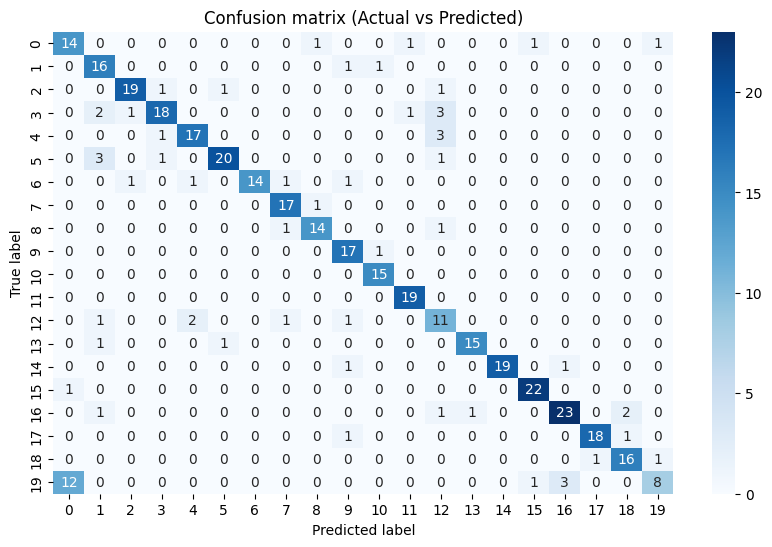

In [13]:
#Confusion matrix visualization
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
plt.title("Confusion matrix (Actual vs Predicted)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [14]:
# Step 3: Sentiment tagging for each blog post
def analyze_polarity(text):
    blob = TextBlob(str(text))
    score = blob.sentiment.polarity
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

blogs_df['sentiment'] = blogs_df['content'].apply(analyze_polarity)
blogs_df['sentiment'].head()

,sentiment
0,Positive
1,Negative
2,Positive
3,Positive
4,Positive


In [15]:
#Sentiment counts
print("\nSentiment counts across all posts:")
print(blogs_df['sentiment'].value_counts())


Sentiment counts across all posts:
sentiment
Positive    1543
Negative     457
Name: count, dtype: int64


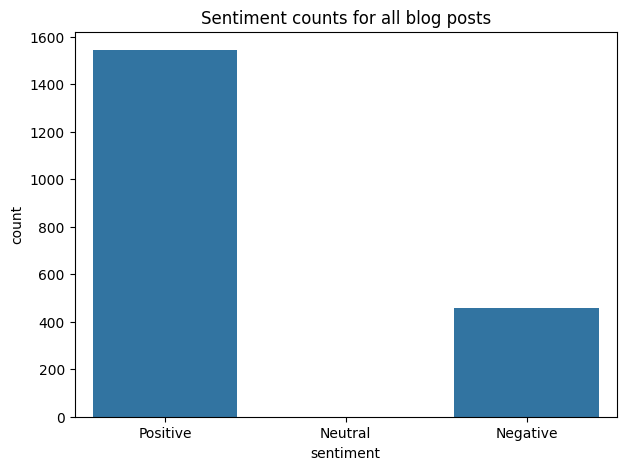

In [16]:
# Plot overall sentiment distribution
plt.figure(figsize=(7,5))
sns.countplot(data=blogs_df, x='sentiment', order=['Positive', 'Neutral', 'Negative'])
plt.title("Sentiment counts for all blog posts")
plt.show()

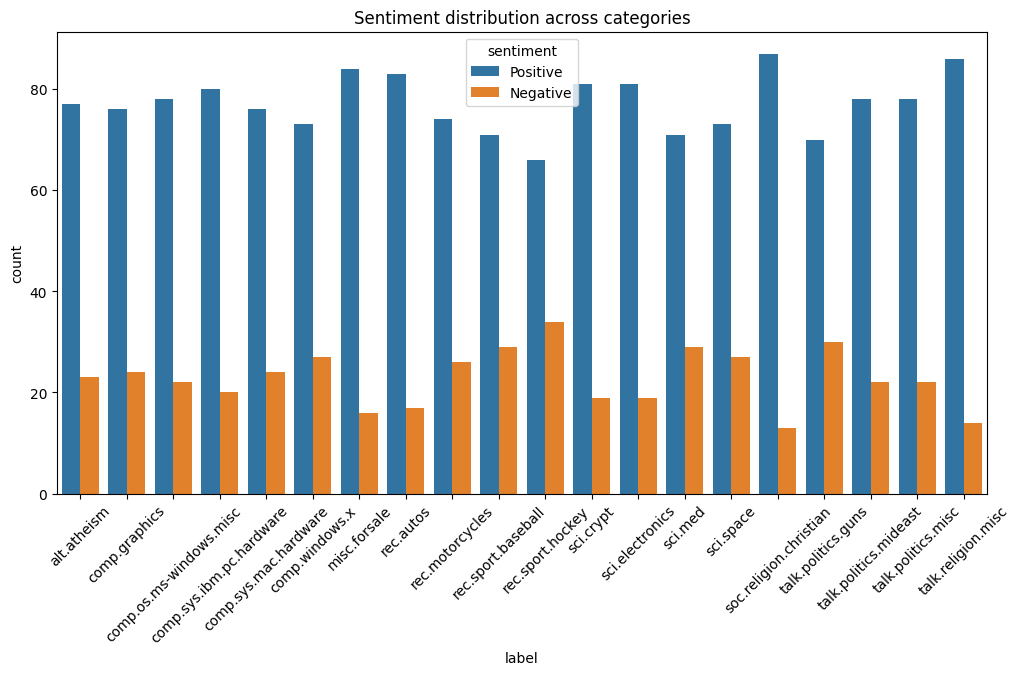

In [17]:
#  Plot sentiment breakdown per category
plt.figure(figsize=(12,6))
sns.countplot(data=blogs_df, x='label', hue='sentiment')
plt.xticks(rotation=45)
plt.title("Sentiment distribution across categories")
plt.show()

# Final notes / discussion
# - Model: Multinomial Naive Bayes works well for bag-of-words / TF-IDF features.
# - TF-IDF helps by reducing weight of very common tokens and highlighting discriminative words.
# - Sentiment tagging here uses TextBlob polarity; beware of sarcasm and domain-specific language.
# - For reproducibility: keep random_state fixed and save the trained vectorizer/model if needed.
# -------------------

# Interview Q&A
# Q1: Why TF-IDF vs raw counts?
# A1: TF-IDF reduces the influence of frequent but uninformative words and emphasizes rarer, informative terms.
# Q2: Why MultinomialNB for text?
# A2: It models token counts/frequencies efficiently and is fast to train and predict.
# Q3: Limits of simple sentiment tools?
# A3: They can miss sarcasm, contextual nuance, and specialized vocabulary.
# Q4: Role of preprocessing?
# A4: Cleaning reduces noise, shrinks feature space, and helps the classifier focus on meaningful signals.
# Q5: Why TextBlob?
# A5: Lightweight and easy to use for polarity scoring (built on NLTK utilities).